# SCADAA Report

In [5]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from exercise2 import DGM_Layer, Net_DGM
from exercise2 import FFN


## Exercise 1.1

In [6]:
class LQR:
    def __init__(self, H, M, sigma, alpha, alpha_s, C, D, R, T) -> None:
        self.H = H 
        self.M = M
        self.sigma = sigma
        self.alpha = alpha 
        self.alpha_s = alpha_s
        self.C = C 
        self.D = D 
        self.R = R
        self.T = T
    

    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat, dtype=torch.float32).reshape((2, 2))  # Convert S_flat to a PyTorch tensor
        dS = (-2 * (self.H.t() @ S) + S @ (self.M) @ (torch.inverse(self.D)) @ (np.transpose(self.M)) @ S - self.C)
        return dS.flatten().detach().numpy()
 

    def solve_ricatti_ode(self, time_grid):
        """
        Solves the LQR problem by integrating the 
        Riccati equation backwards in time.
        """
        # Time points (reversed for backward integration)
        # t_points = np.linspace(0, self.T, 1000)[::-1]  
        intial_cond = self.R.flatten().detach().numpy()

        sol = solve_ivp(
            self.riccati_ode, [self.T.item(), time_grid[0].item()], 
            intial_cond, t_eval=time_grid.numpy()[::-1], method='RK45'
            )
        
        S = torch.tensor(sol.y)

        return S

    def visualize_results(self, t_points, S):
        """
        Visualizes the solution of the Riccati equation 
        or the state/control trajectories.
        """
        # S_00 = [s[0, 0].item() for s in S]
        plt.plot(t_points, S[0, :])
        plt.xlabel('Time')
        plt.ylabel('S[0,0]')
        plt.title('Solution of Riccati Equation over Time')
        plt.show()
        

    def markov_control(self, t_batch, x_batch):
        S = self.solve_ricatti_ode(t_batch).reshape(-1, 2, 2).float()
        x_batch = x_batch.view(x_batch.size(0), 2)
        
        a = - ((torch.inverse(self.D.float()) @ self.M.T) @ S) @ x_batch.unsqueeze(-1)

        return a.squeeze(-1)


    def value_function(self, t_batch, x_batch):
        S = self.solve_ricatti_ode(t_batch).reshape(-1, 2, 2).float()
        x_batch = x_batch.view(x_batch.size(0), 2, 1)

        # Compute the first term: x.transpose(S)x
        x_S_x = torch.matmul(torch.matmul(x_batch.transpose(1, 2), S), x_batch).squeeze()

        # Compute the integral term
        integral_term = 0
        for t, s in zip(t_batch, S):
            # Compute the trace term
            trace = (self.sigma @ self.sigma.T) @ s
            trace_term = torch.trace(trace.view(trace.size(0), -1))

            integral_term += trace_term * (self.T - t) / len(t_batch)

        # Compute the total value function: v(t, x) = x.transpose(S)x + trace_term
        v = x_S_x + integral_term

        return v


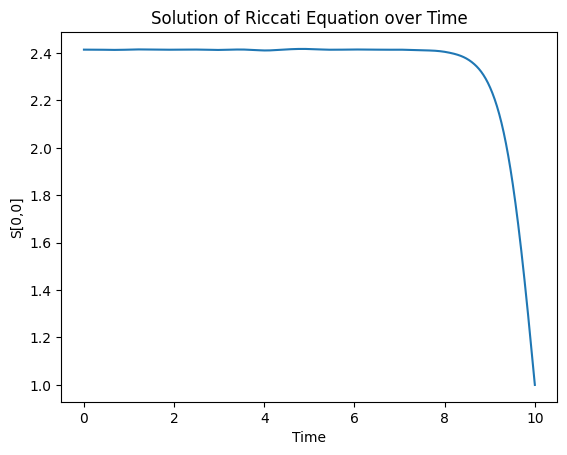

Optimal Markov Control:
tensor([[-7.2402, -2.4134],
        [ 0.0000,  0.0000],
        [ 4.8280, -2.4125]])
Value Function:
tensor([26.9513, 14.8844, -4.4247])


In [7]:
# Example Usage:
# Define problem matrices
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
alpha = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
alpha_s = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(10.0, dtype=torch.float32)

# Initialize LQRController
# controller = LQRController(H, M, D, C, R, T)

# Define time grid
time_grid = torch.linspace(0, T, 1000)

lqr_system = LQR(H, M, sigma, alpha, alpha_s, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid)
lqr_system.visualize_results(torch.flip(time_grid, [0]), S_solution)

# Create sample input tensors
t_batch = torch.tensor([0.5, 0.8, 1.0], dtype=torch.float32)  # Sample time values
x_batch = torch.tensor([
    [[1.0, 2.0]],  
    [[-1.0, 0.0]], 
    [[3.0, -2.0]]  
], dtype=torch.float32)  # Sample spatial values

# Compute the markov control
markov_control = lqr_system.markov_control(t_batch, x_batch)

# Print the computed value function
print("Optimal Markov Control:")
print(markov_control)

# Compute the value function
value_func = lqr_system.value_function(t_batch, x_batch)

# Print the computed value function
print("Value Function:")
print(value_func)



## Exercise 1.2

1. Error

2. Time

In [4]:
#Create error function
def calculate_error(X):
    #We might want to have a better error function tbh
    error = np.linalg.norm(X - np.zeros(X.shape))
    return error



In [8]:

#Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(10.0, dtype=torch.float32)
x0 = [0.0, 0.0]
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
alpha = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
alpha_s = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
N_steps = 10
N_samples = 10

# Define time grid
time_grid = torch.linspace(0, T, 10)
lqr_system = LQR(H, M, sigma, alpha, alpha_s, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid)


In [7]:
# NO 
# def generate_x(T, N_steps, H, M, D, S_solution, sigma, x0):
#     # Convert inputs to PyTorch tensors if they are not already
#     x0 = torch.tensor(x0, dtype=torch.float32)
#     tau = T / N_steps
#     S_matrices = [S_solution[:, i].view(2, 2) for i in range(S_solution.shape[1])]
#     X = [x0]
#     brownian = torch.tensor([np.random.normal() for _ in range(N_steps)], dtype=torch.float32)

#     for i in range(N_steps-1):
#         dw = brownian[i+1] - brownian[i]  # Brownian motion increment
#         a_s = -torch.inverse(D) @ M.T @ S_matrices[i].float() @ X[-1]  # LQR control law
#         print((M@a_s).size())
#         next_val = X[-1] + tau * (H @ X[-1] + M @ a_s) + sigma * dw * torch.sqrt(torch.tensor(tau))
#         X.append(next_val)

#     return X



# print(generate_x(T, N_steps, H.float(), M.float(), D.float(), S_solution.float(), sigma.float(), x0))




torch.Size([2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
[tensor([0., 0.]), tensor([[0.7722, 0.0000],
        [0.0000, 0.7722]]), tensor([[-2.7286,  0.0000],
        [ 0.0000, -2.7286]]), tensor([[2.2495, 0.0000],
        [0.0000, 2.2495]]), tensor([[0.2568, 0.0000],
        [0.0000, 0.2568]]), tensor([[-0.9423,  0.0000],
        [ 0.0000, -0.9423]]), tensor([[-0.3895,  0.0000],
        [ 0.0000, -0.3895]]), tensor([[0.5532, 0.0000],
        [0.0000, 0.5532]]), tensor([[-0.7567,  0.0000],
        [ 0.0000, -0.7567]]), tensor([[-0.1672,  0.0000],
        [ 0.0000, -0.1672]])]


/tmp/ipykernel_2077/2353430190.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_val = X[-1] + tau * (H @ X[-1] + M @ a_s) + sigma * dw * torch.sqrt(torch.tensor(tau))


In [10]:

#Yes
def generate_x(T, N_steps, H, M, D, S_solution, sigma, x0):

    x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1) 
    tau = T / N_steps
    S_matrices = [S_solution[:, i].view(2, 2) for i in range(S_solution.shape[1])]
    X = [x0]
    brownian = torch.randn(N_steps, 2, dtype=torch.float32) 

    for i in range(N_steps-1):
        dw = (brownian[i+1] - brownian[i]).view(2, 1)  # Ensure dw is a 2x1 vector
        # Calculate control action, ensuring it results in a 2x1 vector
        a_s = -torch.inverse(D) @ M.T @ S_matrices[i] @ X[-1]
        # Update state, ensuring result is a 2x1 vector
        next_val = X[-1] + tau * (H @ X[-1] + M @ a_s) + sigma @ dw  # Use matrix-vector product for sigma @ dw

        X.append(next_val.view(2, 1))  # Ensure next_val remains a 2x1 column vector

    return X



# Call the function with corrected inputs
result = generate_x(T, N_steps, H.float(), M.float(), D.float(), S_solution.float(), sigma.float(), x0)
print(result)


[tensor([[0.],
        [0.]]), tensor([[1.3466],
        [1.4320]]), tensor([[-0.9156],
        [-0.9615]]), tensor([[0.6921],
        [2.0711]]), tensor([[-0.3376],
        [-1.1091]]), tensor([[-0.3326],
        [ 2.1609]]), tensor([[ 0.2889],
        [-4.3379]]), tensor([[-2.2235],
        [ 3.0127]]), tensor([[ 2.8024],
        [-0.9645]]), tensor([[1.4720],
        [0.2772]])]


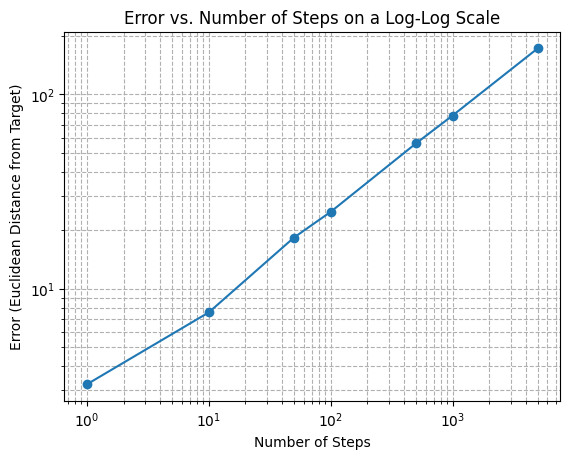

In [10]:
#Plot the error
plt.loglog(N_steps, error, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale')
plt.grid(True, which="both", ls="--")
plt.show()


Exercise 2

In [8]:
# Function to generate training data
def generate_training_data(T, num_samples):
    # t = torch.tensor(np.random.uniform(0, T, num_samples), dtype=torch.float32)
    t = torch.linspace(0, T, num_samples)
    x = torch.tensor(np.random.uniform(-3, 3, (num_samples, 2)), dtype=torch.float32)
    return t, x

tensor([ 3.1684, 10.7900, 16.9818, 10.6295, 10.6295, 10.6295, 10.6295, 33.0435,
        11.3533, 18.5030])


/home/codespace/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 240.37744140625
Epoch 100, Loss: 57.05830001831055
Epoch 200, Loss: 57.057247161865234
Epoch 300, Loss: 57.05721664428711
Epoch 400, Loss: 57.05719757080078
Epoch 500, Loss: 57.057186126708984
Epoch 600, Loss: 57.057167053222656
Epoch 700, Loss: 57.057159423828125
Epoch 800, Loss: 57.057159423828125
Epoch 900, Loss: 57.057151794433594


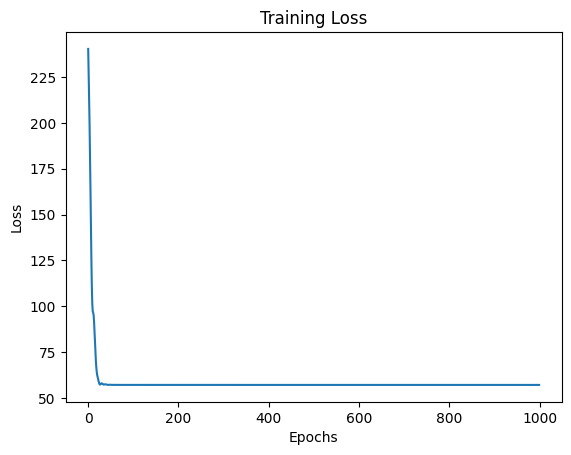

In [9]:
# Function to train the neural network
def train_net_dgm(net_dgm, t_train, x_train, epochs=1000, lr=0.001):
    optimizer = optim.Adam(net_dgm.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        v_pred = net_dgm(t_train.unsqueeze(1), x_train)  # Predict value function
        loss = criterion(v_pred, lqr_system.value_function(t_train, x_train))  # Compute loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Generate training data
T = 10
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
print(lqr_system.value_function(t_train, x_train))

# Initialize the neural network
net_dgm = Net_DGM(dim_x=2, dim_S=100, hidden_size=100)

# Train the neural network
losses = train_net_dgm(net_dgm, t_train, x_train)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


tensor([[ 3.4827,  4.2899],
        [-2.7457, -2.7451],
        [ 1.6053,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  2.7308],
        [ 3.7653,  3.7618],
        [-6.7597, -6.7601]])
Epoch 0, Loss: 9.269732475280762
Epoch 100, Loss: 0.12920208275318146
Epoch 200, Loss: 0.02452228032052517
Epoch 300, Loss: 0.013411189429461956
Epoch 400, Loss: 0.006436525844037533
Epoch 500, Loss: 0.0024765590205788612
Epoch 600, Loss: 0.00069067144067958
Epoch 700, Loss: 0.00013366555504035205
Epoch 800, Loss: 1.91034450836014e-05
Epoch 900, Loss: 2.2872930003359215e-06


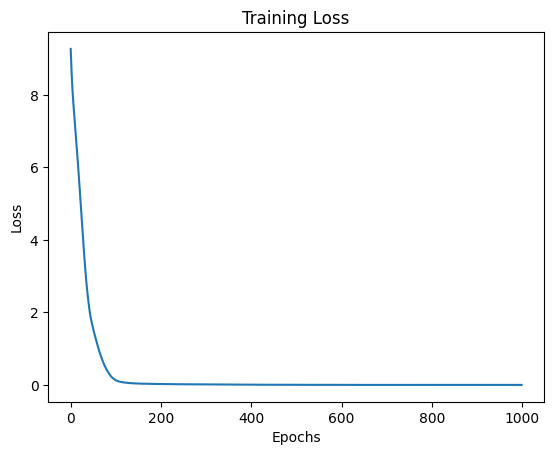

In [10]:
# Function to train the neural network
def train_ffn_net(net_ffn, t_train, x_train, epochs=1000, lr=0.001):
    optimizer = optim.Adam(net_ffn.parameters(), lr=lr)
    # criterion = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        a_pred = net_ffn(torch.cat((t_train.unsqueeze(1), x_train), dim=1))  # Predict markov control
        loss = loss = nn.MSELoss()(a_pred, lqr_system.markov_control(t_train, x_train))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Generate training data
T = 10
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
print(lqr_system.markov_control(t_train, x_train))

# Define the sizes for the FFN network
sizes = [3, 100, 100, 2]  # Input size is 3 (time + 2 coordinates), 2 hidden layers of size 100, output size is 2

# Initialize the neural network
net_ffn = FFN(sizes)

# Train the neural network
losses = train_ffn_net(net_ffn, t_train, x_train)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class DGM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()
    
    def forward(self, t, x):
        t = t.unsqueeze(1)  # Reshape t to (num_samples, 1)
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        hidden2 = self.activation(self.fc2(hidden1))
        output = self.fc3(hidden2)
        return output
    
def loss_function(u, t, x, sigma, H, M, C, D, R, T):
    # Compute PDE residual term
    pde_residual = (
        torch.square(torch.matmul(sigma, sigma.t()).trace()) / 2 * torch.pow(u.diff(x, 2), 2) +
        torch.matmul(u.diff(x), torch.matmul(H, x)) +
        torch.matmul(u.diff(x), torch.matmul(M, torch.tensor([1.0, 1.0]))) +
        torch.matmul(x, torch.matmul(C, x.t())) +
        torch.matmul(torch.tensor([1.0, 1.0]), torch.matmul(D, torch.tensor([1.0, 1.0])))
    )

    # Compute boundary condition term
    boundary_condition = torch.square(u - torch.matmul(x, R))

    # Return the sum of PDE residual and boundary condition terms
    return pde_residual.mean() + boundary_condition.mean()



def train_dgm(model, t_train, x_train, sigma, H, M, C, D, R, T, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        u_pred = model(t_train, x_train)
        loss = loss_function(u_pred, t_train, x_train, sigma, H, M, C, D, R, T)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Define the parameters and matrices
input_dim = 3  # Input dimension (time, space_x, space_y)
hidden_dim = 100  # Hidden layer dimension
output_dim = 1  # Output dimension (solution)
num_samples = 1000  # Number of training samples
T = 1  # End time
epochs = 1000  # Number of training epochs
lr = 0.001  # Learning rate

# Generate training data
t_train, x_train = generate_training_data(T, num_samples)

# Initialize the DGM model
model = DGM(input_dim, hidden_dim, output_dim)

# Train the DGM model
train_dgm(model, t_train, x_train, sigma, H, M, C, D, R, T, epochs, lr)


TypeError: diff(): argument 'n' (position 1) must be int, not Tensor